## Data Analysis

<em>Aaron Wollman, Albin Joseph, Kelsey Richardson Blackwell, Will Huang</em>

In this notebook, the code will look at data from Spotify, Billboard, and the US Bureau of Labor Statistics to try to answer the following questions:
<ul>
    <li>Is there a correlation between unemployment and the Billboard Top 100 Songs Chart?  If so, can the data predict what the next top song might sound like?
    </li>
    <li>
        Are there other musical attributes besides happiness that have a stronger correlation such as danceability, energy, tempo, speech?
    </li>
</ul>

In [8]:
%matplotlib inline

In [30]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import numpy as np
from scipy.stats import linregress
import scipy.stats as st

In [10]:
# Constants


In [11]:
data = pd.read_csv('../data/music_and_unemployment.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)
data.head()

,Track,Artist,Placement,Year,Month,Day,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,Unemployment Rate
0,El Paso,Marty Robbins,1,1960,1,4,0.654,0.452,2.0,-9.709,0.0300,0.835,0.160,0.691,106.662,5.2
1,Why,Frankie Avalon,2,1960,1,4,0.510,0.349,5.0,-8.677,0.0264,0.762,0.130,0.586,94.267,5.2
2,The Big Hurt,Miss Toni Fisher,3,1960,1,4,0.624,0.557,0.0,-8.309,0.0299,0.783,0.173,0.676,123.919,5.2
3,Running Bear,Johnny Preston,4,1960,1,4,0.772,0.297,5.0,-14.679,0.0530,0.854,0.125,0.822,119.987,5.2
4,Heartaches By The Number,Guy Mitchell,6,1960,1,4,0.584,0.589,5.0,-11.203,0.0718,0.463,0.069,0.842,172.484,5.2


In [12]:
# Aaron's Code

In [13]:
from columns import Music_Unemploy_Cols, Unemploy_Cols
from datafiles import music_unemployment, unemployment

In [15]:
# Import Music and Unemployment CSV
music_unemployment = pd.read_csv(music_unemployment, index_col = 0)
music_unemployment.head()

,Track,Artist,Placement,Year,Month,Day,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,Unemployment Rate
0,El Paso,Marty Robbins,1,1960,1,4,0.654,0.452,2.0,-9.709,0.0300,0.835,0.160,0.691,106.662,5.2
1,Why,Frankie Avalon,2,1960,1,4,0.510,0.349,5.0,-8.677,0.0264,0.762,0.130,0.586,94.267,5.2
2,The Big Hurt,Miss Toni Fisher,3,1960,1,4,0.624,0.557,0.0,-8.309,0.0299,0.783,0.173,0.676,123.919,5.2
3,Running Bear,Johnny Preston,4,1960,1,4,0.772,0.297,5.0,-14.679,0.0530,0.854,0.125,0.822,119.987,5.2
4,Heartaches By The Number,Guy Mitchell,6,1960,1,4,0.584,0.589,5.0,-11.203,0.0718,0.463,0.069,0.842,172.484,5.2


In [43]:
unemployement_time = pd.read_csv(unemployment, index_col = 0)
unemployement_time = unemployement_time.dropna()
unemployement_time.head()

,Year,Month,Unemployment Rate
0,1960,1,5.2
1,1960,2,4.8
2,1960,3,5.4
3,1960,4,5.2
4,1960,5,5.1


In [44]:
unemployement_time.dtypes

Year                   int64
Month                  int64
Unemployment Rate    float64
dtype: object

In [45]:
unemployement_time_pivot=unemployement_time.pivot(
    Unemploy_Cols.year, Unemploy_Cols.month, Unemploy_Cols.rate)
unemployement_time_pivot.dropna()
unemployement_time_pivot.head()

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1960,5.2,4.8,5.4,5.2,5.1,5.4,5.5,5.6,5.5,6.1,6.1,6.6
1961,6.6,6.9,6.9,7.0,7.1,6.9,7.0,6.6,6.7,6.5,6.1,6.0
1962,5.8,5.5,5.6,5.6,5.5,5.5,5.4,5.7,5.6,5.4,5.7,5.5
1963,5.7,5.9,5.7,5.7,5.9,5.6,5.6,5.4,5.5,5.5,5.7,5.5
1964,5.6,5.4,5.4,5.3,5.1,5.2,4.9,5.0,5.1,5.1,4.8,5.0


In [ ]:
# Display the Standard Deviation per Year
temp=unemployement_time_pivot.copy()
temp['STD']=[statistics.stdev(temp.loc[index,:]) for index,row in temp.iterrows()]
temp.head()

To show the how the unemployment rate has changed over time, the code will use a heatmap. The darker the shade of blue, the higher the unemployment rate.

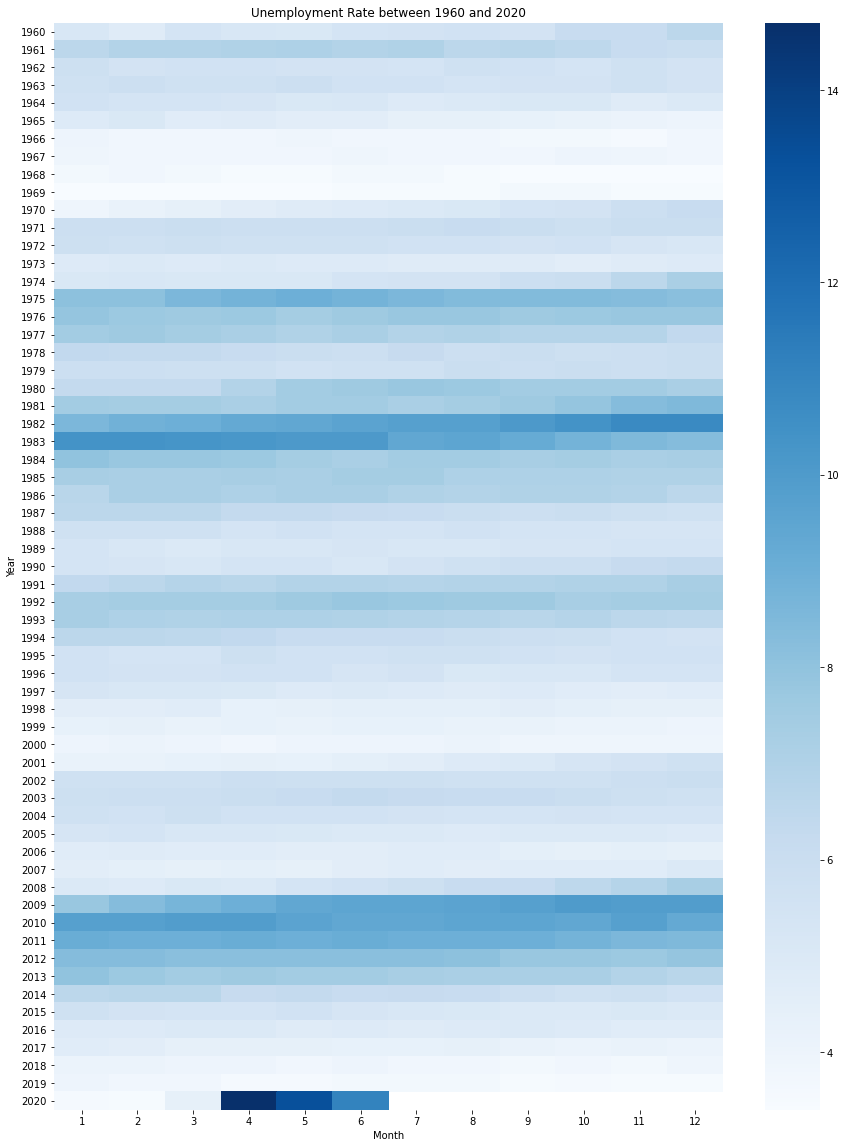

In [18]:
# Show all years in one heatmap.
plt.figure(figsize=(15,20))
sns.heatmap(unemployement_time_pivot,cmap=("Blues"))
plt.title("Unemployment Rate between 1960 and 2020")
plt.show()

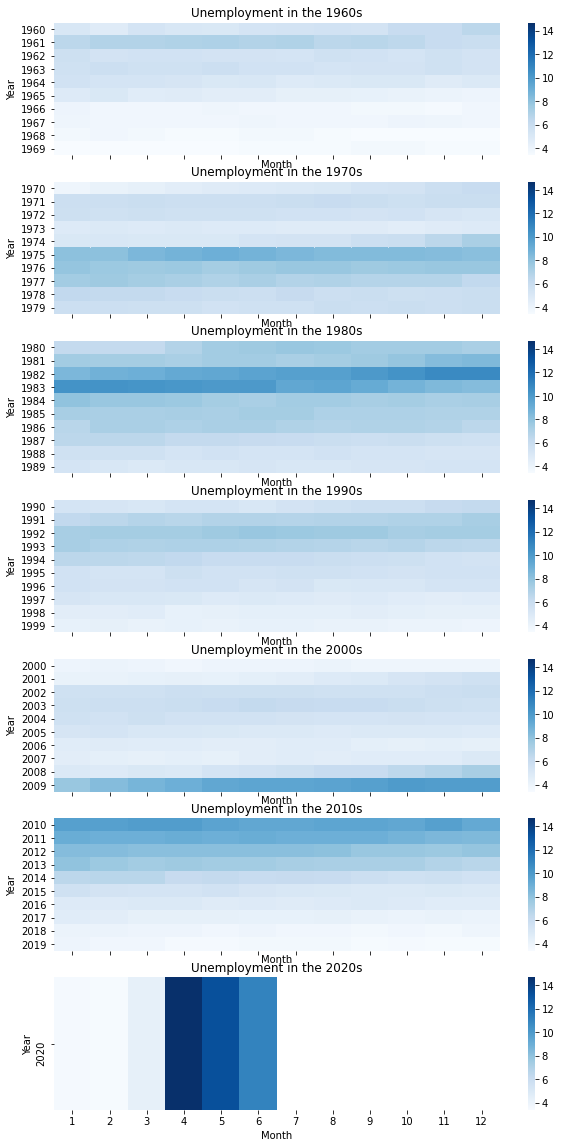

In [21]:
# Show the heatmap per decade.  Should be equivalent to the above graph.
vmax=unemployement_time_pivot.max().max()
vmin=unemployement_time_pivot.min().min()
fig,axes=plt.subplots(7,1,figsize=(10,20),sharex=True)
i = 0
for axis in axes:
    data = unemployement_time_pivot[i*10 : (i+1) * 10]
    axis.set_title(f"Unemployment in the {1960 + (i*10)}s")
    sns.heatmap(data,cmap=("Blues"),ax=axis,vmax=vmax,vmin=vmin)
    i += 1

plt.show()

## Song Valence
[Spotify's API](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/) defines a song's valence as:
<blockquote>"A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)."</blockquote>

For this project, this can be considered our \"happiness\" metric.

## Song Valence vs Unemployment
To compare the song's valence to the unemployment, the code will first try to find a correlation between each month's average valence and the unemployment rate.

In [22]:
# Define a function for plotting a regression
def regression_plot(dataframe, x_col, y_col):
    # Plot the scatter plot
    dataframe.plot(kind="scatter", x = x_col, y = y_col)
    
    # Calculate the correlation coefficient and linear regression model 
    x_values = dataframe[x_col]
    y_values = dataframe[y_col]
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    equation = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    eq_label = f"{equation} \nr-squared = {round(rvalue * rvalue, 3)}"
    regress_plot, = plt.plot(x_values, regress_values, "r-", label=eq_label)
    plt.legend(handles=[regress_plot], loc="best")

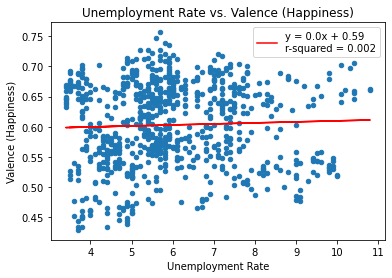

In [23]:
# Group by the song's date
date_cols = [Music_Unemploy_Cols.year, 
             Music_Unemploy_Cols.month, 
             Music_Unemploy_Cols.day]
music_unemployment_gb = music_unemployment.groupby(date_cols)

# Find the average of unemployment rate and weighed valence for each date
avg_music_unemploy = music_unemployment_gb.mean()
rate_v_valence = avg_music_unemploy[[Music_Unemploy_Cols.unemploy_rate, 
                                     Music_Unemploy_Cols.valence]]

# Create a Scatter Graph
regression_plot(rate_v_valence, 
                Music_Unemploy_Cols.unemploy_rate, 
                Music_Unemploy_Cols.valence)
plt.title("Unemployment Rate vs. Valence (Happiness)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Valence (Happiness)")
plt.show()

From the above graph, there is <b>not</b> a good correlation between valence and the unemployment rate. With the above, the data doesn't take the song's placement in the Top 100 into account. Let's try again using a weighted average of the Top 100.

This weighted average will give the number 1 song 101 points, number 2 100 points, and will keep decreasing by 1 point until it assigns the number 100 song 1 point. By doing this weighted average, the placement of a song on the Top 100 will be more meaningful.

In [24]:
# Create a new data point "Weighted Valence"
Music_Unemploy_Cols.weighed_valence = "weighed valence"
weights = (101 - music_unemployment[Music_Unemploy_Cols.placement])
weighed_valence = music_unemployment[Music_Unemploy_Cols.valence] * weights
music_unemployment[Music_Unemploy_Cols.weighed_valence] = weighed_valence
music_unemployment.head()

,Track,Artist,Placement,Year,Month,Day,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,Unemployment Rate,weighed valence
0,El Paso,Marty Robbins,1,1960,1,4,0.654,0.452,2.0,-9.709,0.0300,0.835,0.160,0.691,106.662,5.2,69.100
1,Why,Frankie Avalon,2,1960,1,4,0.510,0.349,5.0,-8.677,0.0264,0.762,0.130,0.586,94.267,5.2,58.014
2,The Big Hurt,Miss Toni Fisher,3,1960,1,4,0.624,0.557,0.0,-8.309,0.0299,0.783,0.173,0.676,123.919,5.2,66.248
3,Running Bear,Johnny Preston,4,1960,1,4,0.772,0.297,5.0,-14.679,0.0530,0.854,0.125,0.822,119.987,5.2,79.734
4,Heartaches By The Number,Guy Mitchell,6,1960,1,4,0.584,0.589,5.0,-11.203,0.0718,0.463,0.069,0.842,172.484,5.2,79.990


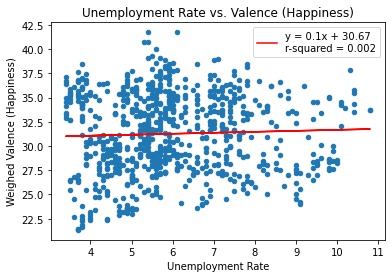

In [25]:
# Group by the song's date
music_unemployment_gb = music_unemployment.groupby(date_cols)

# Find the average of unemployment rate and weighed valence for each date
avg_music_unemploy = music_unemployment_gb.mean()
rate_v_valence = avg_music_unemploy[[Music_Unemploy_Cols.unemploy_rate, 
                                     Music_Unemploy_Cols.weighed_valence]]

# Create a Scatter Graph
regression_plot(rate_v_valence, 
                Music_Unemploy_Cols.unemploy_rate, 
                Music_Unemploy_Cols.weighed_valence)
plt.title("Unemployment Rate vs. Valence (Happiness)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Weighed Valence (Happiness)")
plt.show()

Even with a weighted average, there still isn't a good correlation between the average valence and the unemployment rate. Let's now look to see if there is another musical attribute that might correlate to unemployment.

## Finding an Alternative Music Attribute

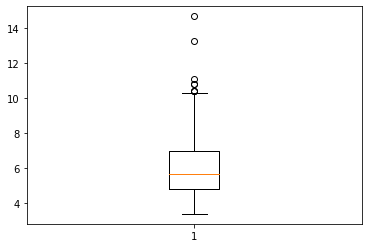

In [51]:
unemployment_rate_list=unemployement_time[Unemploy_Cols.rate]
plt.boxplot(unemployment_rate_list)
plt.show()

In [ ]:
# End of Aaron's Code

In [ ]:
# Kelsey's code

## Unemployment Rate vs. Happiness

We ran a regression for happiness ("valence") versus Unemployment Rate and discovered that the unemployment rate does not impact happiness in a Top 100 hit song. If you look at the plot below, you can visibily see the scattered data points. The r value = 0.1, which means there is almost no relationship between happiness in a song and the unemployment rate.

So we decided to dig a littler deeper and look at the other variables in music.

In [ ]:
# Create a new data point "Weighted Valence"
data["weighed valence"] = data["valence"] * (101 - data["Placement"])
data.head()

In [ ]:
# Group by the song's date
data_gb = data.groupby(["Year", "Month", "Day"])

# Find the average of unemployment rate and weighed valence for each date
rate_v_valence = data_gb.mean()[["Unemployment Rate", "weighed valence"]]

# Create a Scatter Graph
rate_v_valence.plot(kind="scatter", x = "Unemployment Rate", y = "weighed valence")

# Calculate the correlation coefficient and linear regression model 
x_values = rate_v_valence["Unemployment Rate"]
y_values = rate_v_valence["weighed valence"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5,22),fontsize=15,color="red")

plt.title("Unemployment Rate vs. Valence (Happiness)")
plt.xlabel("Unemployment Rate")
plt.ylabel("Weighed Valence (Happiness)")
plt.show()

## Unemployment Rate vs. Energy

We ran a regression for the unemployment rate versus energy and discovered there is a positive relationship between the energy in a song and the unemployment rate.

In [ ]:
data["weighed energy"] = data["energy"] * (101 - data["Placement"])
data["weighed tempo"] = data["tempo"] * (101 - data["tempo"])

In [ ]:
# Group by the song's date
data_gb = data.groupby(["Year", "Month", "Day"])

# Find the average of unemployment rate and weighed valence for each date
rate_v_energy = data_gb.mean()[["Unemployment Rate", "weighed energy"]]

# Create a Scatter Graph
rate_v_energy.plot(kind="scatter", x = "Unemployment Rate", y = "weighed energy")

# Calculate the correlation coefficient and linear regression model 
x_values = rate_v_energy["Unemployment Rate"]
y_values = rate_v_energy["weighed energy"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(5,22),fontsize=15,color="red")

plt.title("Unemployment Rate vs. Energy")
plt.xlabel("Unemployment Rate")
plt.ylabel("Energy")
plt.show()

## Unemployment Rate vs. Tempo

We ran a regression for the unemployment rate versus tempo and discovered there is a slight negative relationship between tempo in a song and the unemployment rate

In [ ]:
# Group by the song's date
data_gb = data.groupby(["Year", "Month", "Day"])

# Find the average of unemployment rate and weighed valence for each date
rate_v_tempo = data_gb.mean()[["Unemployment Rate", "weighed tempo"]]

# Create a Scatter Graph
rate_v_tempo.plot(kind="scatter", x = "Unemployment Rate", y = "weighed tempo")

# Calculate the correlation coefficient and linear regression model 
x_values = rate_v_tempo["Unemployment Rate"]
y_values = rate_v_tempo["weighed tempo"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(8,-1800),fontsize=15,color="red")

plt.title("Unemployment Rate vs. Tempo")
plt.xlabel("Unemployment Rate")
plt.ylabel("Tempo")
plt.show()

In [ ]:
# End of Kelsey's Code

In [ ]:
# Will's Code

In [ ]:
#Unemployment rate monthly data from 1960 to 2019 
unemployment_time=data[['Year','Month','Unemployment Rate']].drop_duplicates().reset_index(drop=True)
unemployment_time.head()

In [ ]:
#unemployment rate data by Year and Month
unemployment_time_pivot=unemployment_time.pivot('Year','Month','Unemployment Rate')
unemployment_time_pivot.head()

In [ ]:
#the maximum of unemplyment rate
vmax=unemployment_time_pivot.max().max()

#the minimum of unemployment rate
vmin=unemployment_time_pivot.min().min()

In [ ]:
#unemployment rate heat map by decades
fig,axes=plt.subplots(6,1,figsize=(15,20))
sns.heatmap(unemployment_time_pivot[:10],cmap=("Blues"),ax=axes[0],vmax=vmax,vmin=vmin)
sns.heatmap(unemployment_time_pivot[10:20],cmap=("Blues"),ax=axes[1],vmax=vmax,vmin=vmin)
sns.heatmap(unemployment_time_pivot[20:30],cmap=("Blues"),ax=axes[2],vmax=vmax,vmin=vmin)
sns.heatmap(unemployment_time_pivot[30:40],cmap=("Blues"),ax=axes[3],vmax=vmax,vmin=vmin)
sns.heatmap(unemployment_time_pivot[40:50],cmap=("Blues"),ax=axes[4],vmax=vmax,vmin=vmin)
sns.heatmap(unemployment_time_pivot[50:],cmap=("Blues"),ax=axes[5],vmax=vmax,vmin=vmin)

In [ ]:
unemployment_rate_list=[]
for i in range(len(unemployment_time_pivot)):
    for j in unemployment_time_pivot.iloc[i,1:]:
        unemployment_rate_list.append(j)

In [ ]:
#check if there is outlier in unemployemnt rate
plt.boxplot(unemployment_rate_list)

In [ ]:
#categorize song by its unemployment rate at the time
# if unemployment rate higher than 7.0, assign into High_Unemployment group
# 7.0 is descided by the 3rd quantile of all the unemployment rate data

high_unemployment_rate=np.quantile(unemployment_rate_list, .75) ###7.0
data["weighed valence"] = data["valence"] * (101 - data["Placement"])
data['High_Unemployment']=data['Unemployment Rate'].apply(lambda x: 1 if x>=high_unemployment_rate else 0)

data.head()

In [ ]:
#the calculation of weighted features could be done together 
#this section should be move above of top of the jupyter nobebook

music_unemployment["weighed valence"] = music_unemployment["valence"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed danceability']=music_unemployment["danceability"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed energy']=music_unemployment["energy"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed key']=music_unemployment["key"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed loudness']=music_unemployment["loudness"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed speechiness']=music_unemployment["speechiness"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed acousticness']=music_unemployment["acousticness"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed liveness']=music_unemployment["liveness"] * (101 - music_unemployment["Placement"])
music_unemployment['weighed tempo']=music_unemployment["tempo"] * (101 - music_unemployment["Placement"])
music_unemployment['High_Unemployment']=music_unemployment['Unemployment Rate'].apply(lambda x: 1 if x>=high_unemployment_rate else 0)

In [ ]:
#we could drop the original scroe and replace it by the weighted score
music_unemployment.head()

In [ ]:
#assign the weighted feature scores to the mean of the monthly feature score
music_unemployment_group=music_unemployment.groupby(['Year','Month','Day'])[
    ['High_Unemployment','Unemployment Rate',
       'weighed valence', 'weighed danceability', 'weighed energy',
       'weighed key', 'weighed loudness', 'weighed speechiness',
       'weighed acousticness', 'weighed liveness', 'weighed tempo']].mean()

In [ ]:
feature_list=['weighed valence', 'weighed danceability', 'weighed energy',
       'weighed key', 'weighed loudness', 'weighed speechiness',
       'weighed acousticness', 'weighed liveness', 'weighed tempo']

In [ ]:
#scatter plots for weigthed feature scroes by unemployment rate
row=0
col=0
fig,axes=plt.subplots(3,3,figsize=(15,15))

for i in feature_list:
    if col>2:
        row+=1
        col=0
        sns.scatterplot(x='Unemployment Rate',y=i,hue='High_Unemployment',data=music_unemployment_group,ax=axes[row][col])
        col+=1
        
    else:
        sns.scatterplot(x='Unemployment Rate',y=i,hue='High_Unemployment',data=music_unemployment_group,ax=axes[row][col])
        col+=1

In [ ]:
#boxplots for weigthed feature scroes by unemployment rate
row=0
col=0
fig,axes=plt.subplots(3,3,figsize=(15,15))
for i in feature_list:
    if col>2:
        row+=1
        col=0
        sns.boxplot(x='High_Unemployment',y=i,data=music_unemployment_group[[i,'High_Unemployment']],ax=axes[row][col])
        col+=1
        
    else:
        sns.boxplot(x='High_Unemployment',y=i,data=music_unemployment_group[[i,'High_Unemployment']],ax=axes[row][col])
        col+=1
        

In [ ]:
#anova test for weighted features
statistic_list=[]
pvalue_list=[]
for i in feature_list:
    group1=music_unemployment_group[i][music_unemployment_group['High_Unemployment']==1]
    group2=music_unemployment_group[i][music_unemployment_group['High_Unemployment']==0]
    statistic=st.f_oneway(group1,group2)[0]
    pvalue=st.f_oneway(group1,group2)[1]
    statistic_list.append(statistic)
    pvalue_list.append(pvalue)
    print(f' ANOVA Result for {i} vs. High_Unemployment\n {st.f_oneway(group1,group2)}\n==================')

In [ ]:
#anova test results df
significant_list=[1 if i <=0.05 else 0 for i in pvalue_list]
anova=pd.DataFrame({'Feature':feature_list,'Statistic':statistic_list,'Pvalue':pvalue_list,'Significant':significant_list})
anova.sort_values('Pvalue')

In [ ]:
#boxplots for the weighted fetures which has significant 
row=0
col=0
fig,axes=plt.subplots(2,3,figsize=(15,10))
for i in anova['Feature'][anova['Significant']==1]:
    if col>2:
        row+=1
        col=0
        sns.boxplot(x='High_Unemployment',y=i,data=music_unemployment_group[[i,'High_Unemployment']],ax=axes[row][col])
        col+=1
        
    else:
        sns.boxplot(x='High_Unemployment',y=i,data=music_unemployment_group[[i,'High_Unemployment']],ax=axes[row][col])
        col+=1
        

In [ ]:
# ANOVA Test on Yearly Base

In [ ]:
music_unemployment_group_y=music_unemployment.groupby(['Year'])[
    ['Unemployment Rate',
       'weighed valence', 'weighed danceability', 'weighed energy',
       'weighed key', 'weighed loudness', 'weighed speechiness',
       'weighed acousticness', 'weighed liveness', 'weighed tempo']].mean()
music_unemployment_group_y['High_Unemployment']=music_unemployment_group_y['Unemployment Rate'].apply(lambda x: 1 if x>=high_unemployment_rate else 0)

In [ ]:
statistic_list=[]
pvalue_list=[]
for i in feature_list:
    group1=music_unemployment_group_y[i][music_unemployment_group_y['High_Unemployment']==1]
    group2=music_unemployment_group_y[i][music_unemployment_group_y['High_Unemployment']==0]
    statistic=st.f_oneway(group1,group2)[0]
    pvalue=st.f_oneway(group1,group2)[1]
    statistic_list.append(statistic)
    pvalue_list.append(pvalue)
    print(f' ANOVA Result for {i} vs. High_Unemployment\n {st.f_oneway(group1,group2)}\n==================')

In [ ]:
significant_list=[1 if i <=0.05 else 0 for i in pvalue_list]
anova=pd.DataFrame({'Feature':feature_list,'Statistic':statistic_list,'Pvalue':pvalue_list,'Significant':significant_list})
anova.sort_values('Pvalue')

In [ ]:
#scatter plots for weigthed feature scroes by unemployment rate
row=0
col=0
fig,axes=plt.subplots(3,3,figsize=(15,15))

for i in feature_list:
    if col>2:
        row+=1
        col=0
        sns.scatterplot(x='Unemployment Rate',y=i,hue='High_Unemployment',data=music_unemployment_group_y,ax=axes[row][col])
        col+=1
        
    else:
        sns.scatterplot(x='Unemployment Rate',y=i,hue='High_Unemployment',data=music_unemployment_group_y,ax=axes[row][col])
        col+=1

In [ ]:
n=0
fig,axes=plt.subplots(2,1,figsize=(10,10))
for i in anova['Feature'][anova['Significant']==1]:
    sns.boxplot(x='High_Unemployment',y=i,data=music_unemployment_group_y[[i,'High_Unemployment']],ax=axes[n])
    n+=1
        

In [ ]:
#Test

In [ ]:
# End of Will's Code

## Conclusion

Happiness in a song did not have a strong correlation with the U.S. Employment Rate. However, we did discover that energy does have a correlation. When there is a high unemployment rate in the U.S., the top billboard songs are more likely to have higher energy than when there is a low unemployment rate.

This is not great news for Taylor Swift's new album "folklore" that came out last week.